# PROJECT: PHAN TICH MANG LUOI SAN PHAM AMAZON
## De tai: Phan tich Cau truc Loi-Ngoai vi & Goi y Ban cheo (Core-Periphery Analysis & Cross-sell Recommendation)

**Muc tieu:** Phan tich mang luoi dong mua hang (Co-purchasing) cua Amazon de xay dung he thong goi y ban cheo hieu qua, ket hop giua phuong phap Heuristic va Machine Learning.

**Quy trinh thuc hien (Pipeline):**
1.  **Xu ly du lieu (Data Processing):** Loc danh muc de dam bao tinh dai dien.
2.  **Phan tich cau truc (Structural Analysis):** Thong ke mang luoi co ban.
3.  **Phan ra Loi-Ngoai vi (Core-Periphery Decomposition):** Dung thuat toan K-core de phan loai san pham thanh Core (Hot), Inner (Dem) va Outer (Ngach).
4.  **Goi y ban cheo (Cross-sell Recommendation):** Xay dung bang goi y co so dua tren cac chi so Heuristic (Jaccard, Adamic-Adar...).
5.  **Mo hinh du doan (Link Prediction Model):** Huan luyen mo hinh Logistic Regression (co Scaling & Tuning) de toi uu hoa do chinh xac.
6.  **Nghien cuu tinh huong (Case Study):** So sanh hieu qua giua ML va Heuristic tren cac node cu the.

In [1]:
# Import các thư viện cần thiết cho phân tích đồ thị, xử lý dữ liệu và học máy
import os, gzip, itertools, math, random
from collections import defaultdict, Counter
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

# Cấu hình hiển thị
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
print(f"NetworkX version: {nx.__version__}")

NetworkX version: 3.6.1


### PART 1: DATA LOADING & PREPROCESSING
**Mục đích:**
- Nạp dữ liệu đồ thị và cộng đồng.
- Chọn ra danh mục sản phẩm (Category) lớn đầu tiên để phân tích chuyên sâu để lấy mẫu đồ thị con (Subgraph) nhằm giảm tải tính toán nhưng vẫn giữ được cấu trúc topo quan trọng.

In [2]:
# Cố gắng gắn kết Google Drive để truy cập dữ liệu
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = "/content/drive/My Drive/Colab Notebooks/SNA/"
except:
    # Nếu không ở Colab, sử dụng thư mục dữ liệu cục bộ
    DATA_DIR = "./data/"
    print("Môi trường cục bộ được phát hiện.")

# Định nghĩa đường dẫn đến các file dữ liệu
EDGE_PATH = os.path.join(DATA_DIR, "com-amazon.ungraph.txt")
CMTY_PATH = os.path.join(DATA_DIR, "com-amazon.all.dedup.cmty.txt")

# Hàm đọc đồ thị từ file cạnh
def read_ungraph(path):
    G = nx.Graph() # Khởi tạo đồ thị rỗng
    if not os.path.exists(path):
        # Cảnh báo nếu không tìm thấy file và tạo đồ thị mẫu để demo
        print("Cảnh báo: Không tìm thấy file cạnh. Tạo đồ thị mẫu để demo.")
        G.add_edges_from([(i, i+1) for i in range(500)] + [(0, 50), (0, 10), (10, 20), (5, 150)])
        return G
    # Đọc từng dòng trong file để thêm cạnh vào đồ thị
    with open(path, "rt") as f:
        for line in f:
            if line.startswith("#") or not line.strip(): continue # Bỏ qua dòng comment hoặc dòng trống
            try:
                a, b = line.strip().split() # Tách hai đỉnh
                G.add_edge(int(a), int(b)) # Thêm cạnh vào đồ thị
            except: continue # Bỏ qua lỗi định dạng dòng
    return G

# Hàm đọc các cộng đồng từ file
def read_communities(path):
    communities = [] # Danh sách chứa các cộng đồng
    if not os.path.exists(path):
        print("Cảnh báo: Không tìm thấy file cộng đồng.")
        return []
    # Đọc từng dòng, mỗi dòng là một cộng đồng
    with open(path, "rt") as f:
        for line in f:
            nodes = [int(x) for x in line.strip().split() if x] # Chuyển đổi các node thành số nguyên
            if nodes:
                communities.append(nodes) # Thêm cộng đồng vào danh sách
    return communities

Mounted at /content/drive


In [3]:
print("Đang nạp đồ thị đầy đủ và các cộng đồng...")
G_full = read_ungraph(EDGE_PATH) # Đọc đồ thị đầy đủ
# Loại bỏ các cạnh tự lặp (self-loops) để phân tích rõ ràng hơn
G_full.remove_edges_from(nx.selfloop_edges(G_full))
communities = read_communities(CMTY_PATH) # Đọc thông tin các cộng đồng

# In thông tin tổng quan về đồ thị đầy đủ và số lượng cộng đồng
print(f"   - Đồ thị đầy đủ: {G_full.number_of_nodes():,} node, {G_full.number_of_edges():,} cạnh")
print(f"   - Tổng số cộng đồng được phát hiện: {len(communities):,}")

Đang nạp đồ thị đầy đủ và các cộng đồng...
   - Đồ thị đầy đủ: 334,863 node, 925,872 cạnh
   - Tổng số cộng đồng được phát hiện: 75,149


In [4]:
print("Đang phân tích các danh mục (kiểm tra 10 danh mục lớn đầu tiên)...")

cat_stats = [] # Lưu trữ thống kê của các danh mục
# Chỉ phân tích các cộng đồng đủ lớn (hơn 1000 node) để tiết kiệm thời gian tính toán
valid_communities = [c for c in communities if len(c) > 1000]

# Lặp qua 10 cộng đồng lớn nhất để thu thập thống kê
for i, nodes in enumerate(valid_communities[:10]):
    subg = G_full.subgraph(nodes) # Tạo đồ thị con từ các node của cộng đồng
    n = subg.number_of_nodes() # Số lượng node
    e = subg.number_of_edges() # Số lượng cạnh
    density = nx.density(subg) # Mật độ đồ thị
    # Tìm node có bậc cao nhất trong đồ thị con (có thể đại diện cho một sản phẩm "hot" trong danh mục)
    max_deg = max([d for n, d in subg.degree()]) if n > 0 else 0

    cat_stats.append({
        'Cat_ID': i,
        'Nodes': n,
        'Edges': e,
        'Density': f"{density:.5f}",
        'Max_Degree': max_deg
    })

df_cat = pd.DataFrame(cat_stats).sort_values('Nodes', ascending=False) # Tạo DataFrame và sắp xếp theo số lượng node
display(df_cat)

# Chọn danh mục lớn nhất để phân tích chuyên sâu
selected_idx = df_cat.iloc[0]['Cat_ID'] # ID của danh mục lớn nhất
selected_nodes = valid_communities[selected_idx] # Các node thuộc danh mục đó
G_category = G_full.subgraph(selected_nodes).copy() # Tạo đồ thị cho danh mục đã chọn

# In thông tin về danh mục đã chọn
print(f"\nID danh mục được chọn: {selected_idx}")
print(f"   - Kích thước: {G_category.number_of_nodes():,} node, {G_category.number_of_edges():,} cạnh")

Đang phân tích các danh mục (kiểm tra 10 danh mục lớn đầu tiên)...


,Cat_ID,Nodes,Edges,Density,Max_Degree
4,4,5969,13519,0.00076,113
5,5,4319,8860,0.00095,100
9,9,3853,9025,0.00122,86
7,7,3777,9400,0.00132,102
8,8,3716,9218,0.00134,100
3,3,2068,4281,0.00200,68
0,0,1819,5149,0.00311,65
1,1,1691,3300,0.00231,93
6,6,1586,2722,0.00217,52
2,2,1512,2822,0.00247,90



ID danh mục được chọn: 4
   - Kích thước: 5,969 node, 13,519 cạnh


Đang đánh giá chất lượng lấy mẫu (Phân phối bậc)...


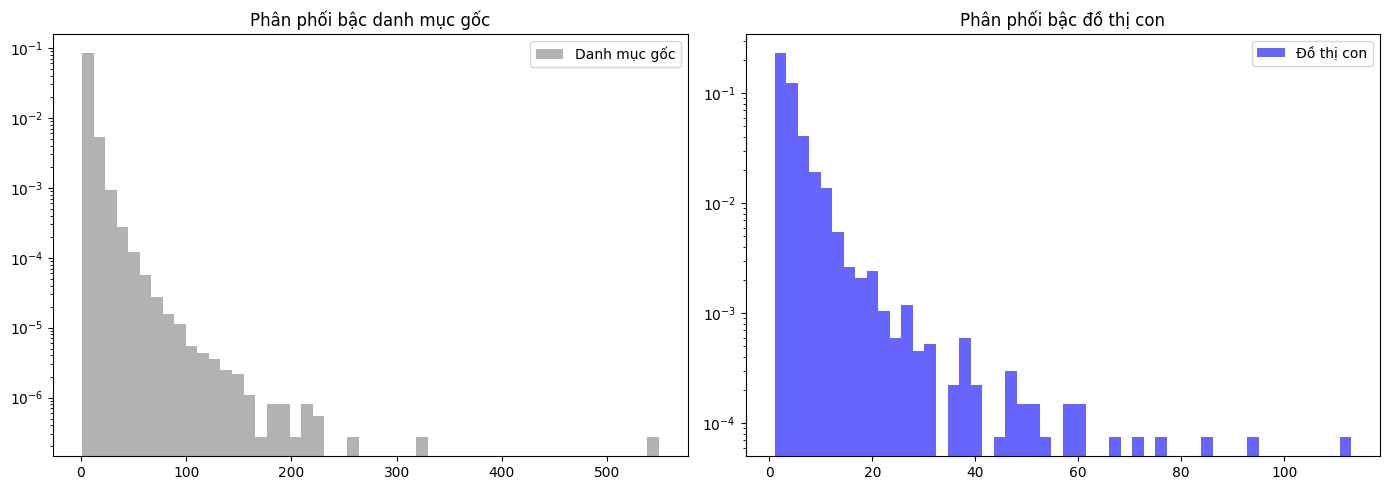

So sánh thống kê:


,Chỉ số,Gốc,Đồ thị con
0,Bậc trung bình,5.529855,4.529737
1,Hệ số phân cụm,0.396746,0.333196


In [5]:
# ĐÁNH GIÁ CHẤT LƯỢNG LẤY MẪU (KIỂM TRA CẤU TRÚC ĐỒ THỊ)
print("Đang đánh giá chất lượng lấy mẫu (Phân phối bậc)...")

# Tạo hai biểu đồ con để so sánh phân phối bậc
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ phân phối bậc của Danh mục gốc (G_full)
deg_orig = [d for n, d in G_full.degree()] # Lấy danh sách bậc của các node
axes[0].hist(deg_orig, bins=50, density=True, alpha=0.6, color='gray', label='Danh mục gốc')
axes[0].set_title("Phân phối bậc danh mục gốc")
axes[0].set_yscale('log') # Sử dụng thang đo log cho trục y để dễ nhìn các bậc cao
axes[0].legend()

# Biểu đồ phân phối bậc của đồ thị con (G_category)
deg_samp = [d for n, d in G_category.degree()] # Lấy danh sách bậc của các node
axes[1].hist(deg_samp, bins=50, density=True, alpha=0.6, color='blue', label='Đồ thị con')
axes[1].set_title("Phân phối bậc đồ thị con")
axes[1].set_yscale('log') # Sử dụng thang đo log cho trục y
axes[1].legend()

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ
plt.show()

# So sánh các chỉ số cấu trúc cơ bản giữa đồ thị gốc và đồ thị con đã lấy mẫu
print("So sánh thống kê:")
stats_df = pd.DataFrame({
    'Chỉ số': ['Bậc trung bình', 'Hệ số phân cụm'],
    'Gốc': [np.mean(deg_orig), nx.average_clustering(G_full)],
    'Đồ thị con': [np.mean(deg_samp), nx.average_clustering(G_category)]
})
display(stats_df)

### **PART 2: NETWORK STATISTICS ANALYSIS**
* **Degree Distribution:** Tính toán và vẽ biểu đồ phân phối bậc.
* **Clustering Coefficient:** Tính hệ số phân cụm trung bình để đo lường mức độ liên kết chặt chẽ giữa các nhóm sản phẩm.
* **Connected Components:** Kiểm tra tính liên thông của đồ thị con đã chọn.
* **Phân tích Assortativity**

--- Thống kê đồ thị cho đồ thị con đã chọn (H) ---
Phân phối bậc (Top 20):
Bậc 3: 1117 node
Bậc 2: 1110 node
Bậc 4: 953 node
Bậc 1: 867 node
Bậc 5: 683 node
Bậc 6: 329 node
Bậc 7: 216 node
Bậc 8: 144 node
Bậc 9: 114 node
Bậc 10: 79 node
Bậc 11: 65 node
Bậc 12: 39 node
Bậc 14: 38 node
Bậc 13: 35 node
Bậc 15: 22 node
Bậc 19: 15 node
Bậc 18: 15 node
Bậc 17: 13 node
Bậc 16: 13 node
Bậc 20: 12 node


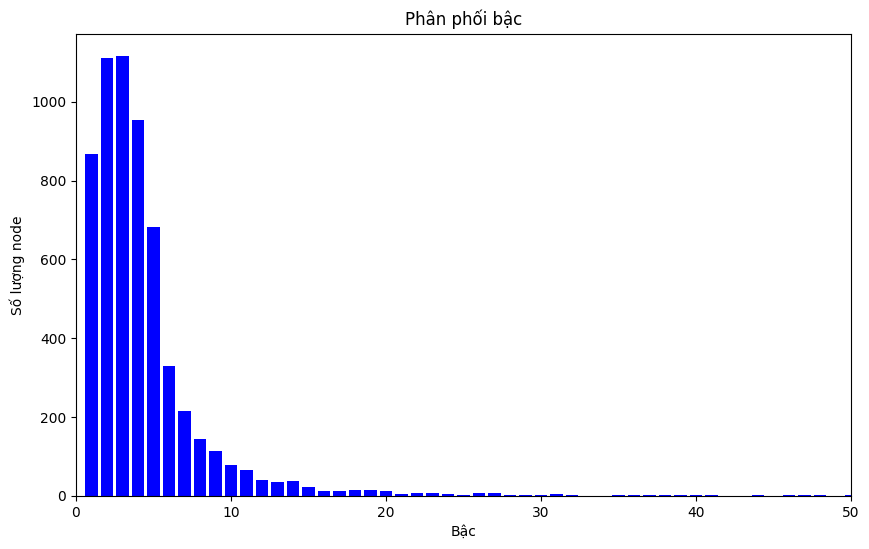


Thành phần liên thông:
Số lượng thành phần liên thông: 1
Kích thước của thành phần liên thông lớn nhất: 5,969
Tỷ lệ node trong thành phần liên thông lớn nhất: 1.0000

Hệ số phân cụm trung bình: 0.3332

Hệ số phân cụm cho các node có bậc cao nhất:
Node 321808: 0.0224
Node 278985: 0.0202
Node 272295: 0.0304
Node 138502: 0.0351
Node 52575: 0.0479
Node 90010: 0.0503
Node 4202: 0.0328
Node 150156: 0.0350
Node 54547: 0.0403
Node 182785: 0.0333

Phân tích Assortativity theo bậc:
Hệ số Assortativity theo bậc: -0.0975
  => Đồ thị có tính phân tầng nghịch (Disassortative): các node có bậc cao có xu hướng kết nối với các node có bậc thấp.


In [6]:
print("--- Thống kê đồ thị cho đồ thị con đã chọn (H) ---")
# Gán biến G bằng đồ thị con để tiện phân tích
G = G_category

# Phân phối bậc (Degree Distribution)
# Sắp xếp các bậc của node theo thứ tự giảm dần
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
# Đếm số lần xuất hiện của mỗi bậc
degree_counts = Counter(degree_sequence)
print("Phân phối bậc (Top 20):")
# In ra 20 bậc phổ biến nhất
for degree, count in degree_counts.most_common(20):
    print(f"Bậc {degree}: {count} node")

# Vẽ biểu đồ phân phối bậc
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.keys(), degree_counts.values(), width=0.8, color='b')
plt.title("Phân phối bậc")
plt.xlabel("Bậc")
plt.ylabel("Số lượng node")
plt.xlim(0, 50) # Giới hạn trục x để dễ nhìn
plt.show()

# Phân tích thành phần liên thông (Connected Components Analysis)
print("\nThành phần liên thông:")
if G.is_directed(): # Kiểm tra nếu đồ thị có hướng
    print(f"Số lượng thành phần liên thông mạnh: {nx.number_strongly_connected_components(G)}")
    print(f"Số lượng thành phần liên thông yếu: {nx.number_weakly_connected_components(G)}")
    largest_cc = max(nx.weakly_connected_components(G), key=len)
else: # Nếu đồ thị vô hướng
    print(f"Số lượng thành phần liên thông: {nx.number_connected_components(G):,}")
    largest_cc = max(nx.connected_components(G), key=len) # Tìm thành phần liên thông lớn nhất

# In thông tin về thành phần liên thông lớn nhất
print(f"Kích thước của thành phần liên thông lớn nhất: {len(largest_cc):,}")
print(f"Tỷ lệ node trong thành phần liên thông lớn nhất: {len(largest_cc) / G.number_of_nodes():.4f}")

# Hệ số phân cụm trung bình (Average Clustering Coefficient)
avg_clustering_coefficient = nx.average_clustering(G)
print(f"\nHệ số phân cụm trung bình: {avg_clustering_coefficient:.4f}")

# Hệ số phân cụm cho một số node có bậc cao nhất
print("\nHệ số phân cụm cho các node có bậc cao nhất:")
# Lấy 10 node có bậc cao nhất
top_degree_nodes = [n for n, d in sorted(G.degree(), key=lambda item: item[1], reverse=True)][:10]
# Tính hệ số phân cụm cho các node này
clustering_coefficients = nx.clustering(G, top_degree_nodes)
for node, cc in clustering_coefficients.items():
    print(f"Node {node}: {cc:.4f}")

# Phân tích Assortativity theo bậc (Degree Assortativity)
print("\nPhân tích Assortativity theo bậc:")
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Hệ số Assortativity theo bậc: {degree_assortativity:.4f}")
if degree_assortativity > 0:
    print("  => Đồ thị có tính phân tầng theo bậc (Assortative): các node có bậc cao có xu hướng kết nối với các node có bậc cao khác.")
elif degree_assortativity < 0:
    print("  => Đồ thị có tính phân tầng nghịch (Disassortative): các node có bậc cao có xu hướng kết nối với các node có bậc thấp.")
else:
    print("  => Đồ thị có tính phân tầng trung tính: không có xu hướng rõ rệt trong việc kết nối giữa các node có bậc khác nhau.")

# Gán lại G = H để đảm bảo các ô tiếp theo sử dụng đúng đồ thị
G = G_category

### **PART 3: CORE-PERIPHERY STRUCTURE ANALYSIS**
* **K-core Decomposition:** Thực hiện thuật toán phân rã K-core để xác định "lớp vỏ" của từng node.
* **Node Classification:** Phân loại sản phẩm thành 3 nhóm dựa trên chỉ số K-core:
    * `Core Zone`: Sản phẩm trung tâm (Anchor items).
    * `Inner Periphery`: Vùng đệm.
    * `Outer Periphery`: Sản phẩm ngách/rìa mạng lưới.
* **Visualization:** Trực quan hóa đồ thị với màu sắc phân biệt giữa Core (Lõi) và Periphery (Ngoại vi).

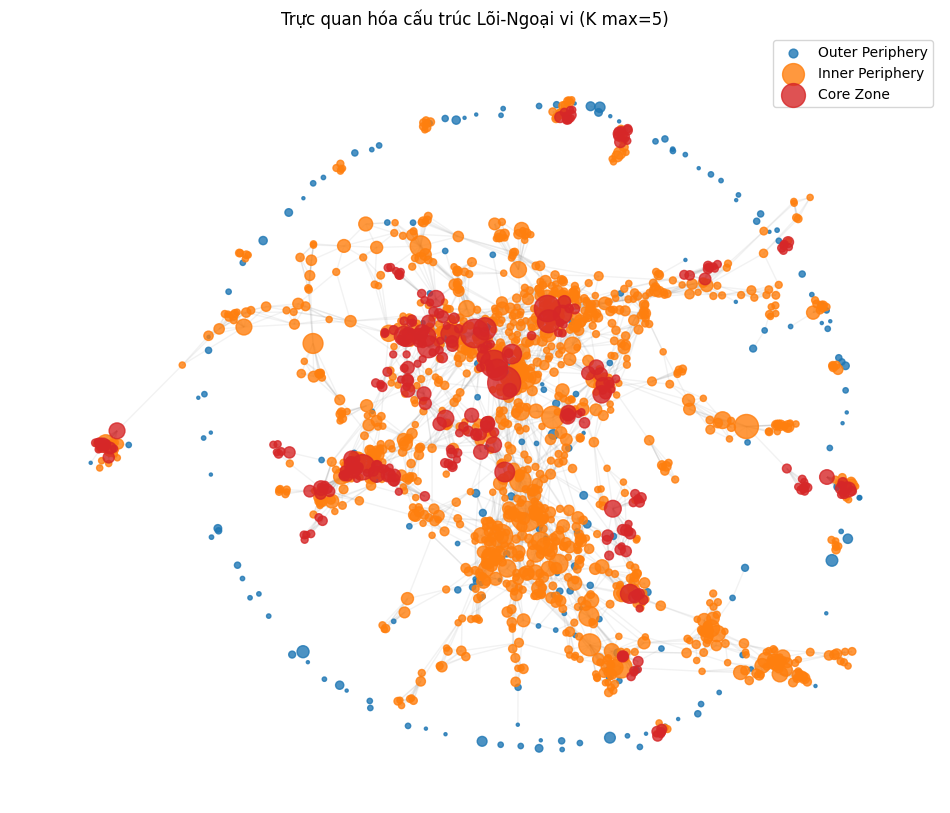

In [7]:
# 1. Phân loại Node dựa trên K-core Decomposition
core_nums = nx.core_number(G_category) # Tính k-core number cho mỗi node trong đồ thị G_category
max_k = max(core_nums.values()) # Tìm giá trị k-core number lớn nhất
node_classes = {} # Dictionary để lưu trữ phân loại của từng node

# Phân loại các node thành 'Core Zone', 'Inner Periphery', 'Outer Periphery'
for n, k in core_nums.items():
    if k == max_k:
        node_classes[n] = 'Core Zone' # Node thuộc Core Zone nếu k-core bằng k max
    elif k >= max_k * 0.7:
        node_classes[n] = 'Inner Periphery' # Node thuộc Inner Periphery nếu k-core >= 70% k max
    else:
        node_classes[n] = 'Outer Periphery' # Node thuộc Outer Periphery nếu k-core thấp hơn

# 2. Trực quan hóa đồ thị con với các phân loại node
plt.figure(figsize=(12, 10))
# Chọn các node để vẽ: tất cả Core và Inner, cùng với một số mẫu ngẫu nhiên từ Outer
nodes_to_draw = [n for n, c in node_classes.items() if c != 'Outer Periphery']
outer_sample = [n for n, c in node_classes.items() if c == 'Outer Periphery']
if len(outer_sample) > 200:
    nodes_to_draw += random.sample(outer_sample, 200) # Lấy mẫu ngẫu nhiên 200 node từ Outer

H_draw = G_category.subgraph(nodes_to_draw) # Tạo đồ thị con chỉ với các node được chọn để vẽ
pos = nx.spring_layout(H_draw, k=0.15, seed=42) # Tính toán vị trí các node bằng thuật toán Spring Layout
# Định nghĩa màu sắc cho từng loại node
color_map = {'Core Zone': '#d62728', 'Inner Periphery': '#ff7f0e', 'Outer Periphery': '#1f77b4'}

# Vẽ các node theo từng loại với màu sắc và kích thước khác nhau
for label in ['Outer Periphery', 'Inner Periphery', 'Core Zone']:
    nodelist = [n for n in H_draw.nodes() if node_classes[n] == label] # Lấy danh sách node của từng loại
    if not nodelist: continue # Bỏ qua nếu không có node nào thuộc loại này
    sizes = [G_category.degree(n) * 5 for n in nodelist] # Kích thước node tỷ lệ với bậc của nó
    nx.draw_networkx_nodes(H_draw, pos, nodelist=nodelist, node_color=color_map[label],
                           node_size=sizes, label=label, alpha=0.8)

# Vẽ các cạnh của đồ thị
nx.draw_networkx_edges(H_draw, pos, alpha=0.1, edge_color='gray')
plt.title(f"Trực quan hóa cấu trúc Lõi-Ngoại vi (K max={max_k})")
plt.legend() # Hiển thị chú giải
plt.axis('off') # Tắt trục tọa độ
plt.show()

Đang tính toán và trực quan hóa Ma trận mật độ...

Ma trận mật độ:


,Core Zone,Inner Periphery,Outer Periphery
Core Zone,0.022103,0.002388,0.000588
Inner Periphery,0.002388,0.003917,0.000497
Outer Periphery,0.000588,0.000497,0.000521


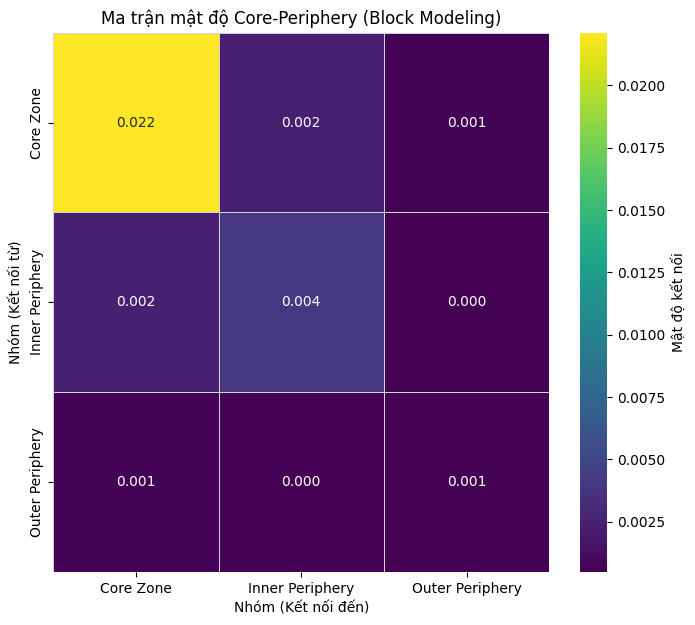

In [8]:
print("Đang tính toán và trực quan hóa Ma trận mật độ...")

# Sắp xếp các nhãn lớp theo thứ tự mong muốn
class_labels = ['Core Zone', 'Inner Periphery', 'Outer Periphery']

# Đếm số node trong mỗi lớp
node_counts_per_class = Counter(node_classes.values())

# Khởi tạo ma trận để lưu trữ số lượng cạnh thực tế và tiềm năng
actual_edges_matrix = pd.DataFrame(0, index=class_labels, columns=class_labels, dtype=int)
potential_edges_matrix = pd.DataFrame(0, index=class_labels, columns=class_labels, dtype=int)

# Đếm số cạnh thực tế giữa các cặp lớp
for u, v in G_category.edges():
    class_u = node_classes.get(u, 'Unknown')
    class_v = node_classes.get(v, 'Unknown')

    if class_u in class_labels and class_v in class_labels:
        actual_edges_matrix.loc[class_u, class_v] += 1
        if class_u != class_v:
            actual_edges_matrix.loc[class_v, class_u] += 1 # Đồ thị vô hướng, cạnh (u,v) = (v,u)

# Tính số cạnh tiềm năng giữa các cặp lớp
for i in class_labels:
    for j in class_labels:
        count_i = node_counts_per_class[i]
        count_j = node_counts_per_class[j]

        if i == j:
            # Số cạnh tiềm năng trong cùng một lớp (không bao gồm self-loops)
            potential_edges_matrix.loc[i, j] = count_i * (count_i - 1) // 2
        else:
            # Số cạnh tiềm năng giữa hai lớp khác nhau
            potential_edges_matrix.loc[i, j] = count_i * count_j

# Tính ma trận mật độ
density_matrix = actual_edges_matrix / potential_edges_matrix
# Xử lý trường hợp chia cho 0 (nếu không có node hoặc không có cạnh tiềm năng)
density_matrix = density_matrix.fillna(0)

print("\nMa trận mật độ:")
display(density_matrix)

# Trực quan hóa ma trận mật độ bằng heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(
density_matrix,
annot=True,
cmap='viridis',
fmt=".3f",
cbar_kws={'label': 'Mật độ kết nối'},
linewidths=.5,
linecolor='lightgray'
)
plt.title('Ma trận mật độ Core-Periphery (Block Modeling)')
plt.xlabel('Nhóm (Kết nối đến)')
plt.ylabel('Nhóm (Kết nối từ)')
plt.show()

### PART 4: CROSS-SELL RECOMMENDATION (HEURISTICS)
**Mục đích:**
- Xây dựng danh sách gợi ý cơ bản (Baseline) dựa trên các chỉ số cấu trúc mạng.
- Các chỉ số sử dụng: **Jaccard, Adamic-Adar, Preferential Attachment, Resource Allocation**.
- Tạo bảng tổng hợp Cross-sell cho các sản phẩm Core.
- Đánh giá kết quả

Đang tính điểm các cặp hiện có: 100%|██████████| 112/112 [00:00<00:00, 2592.73it/s]


--- BẢNG GỢI Ý BÁN CHÉO (XEM TRƯỚC) ---


,Base_Item,Candidate,Type,Jaccard,Adamic_Adar,Pref_Attach,Resource_Alloc
43,439291,495991,Existing,0.169355,13.097289,5100.0,4.154798
96,121603,453695,Existing,0.155556,3.710253,420.0,1.070760
88,121603,33403,Existing,0.133333,3.131317,378.0,0.892982
24,90010,57960,Existing,0.128205,5.392798,1152.0,1.573810
108,514644,166051,Existing,0.128205,2.980226,340.0,0.933333
102,253538,335928,Existing,0.116279,2.299785,351.0,0.580599
111,514644,488790,Existing,0.114286,2.235075,170.0,0.666667
89,121603,57863,Existing,0.111111,2.697023,336.0,0.792982
79,83665,240866,Existing,0.093023,1.509302,280.0,0.307749
94,121603,379631,Existing,0.093023,1.645220,210.0,0.362427


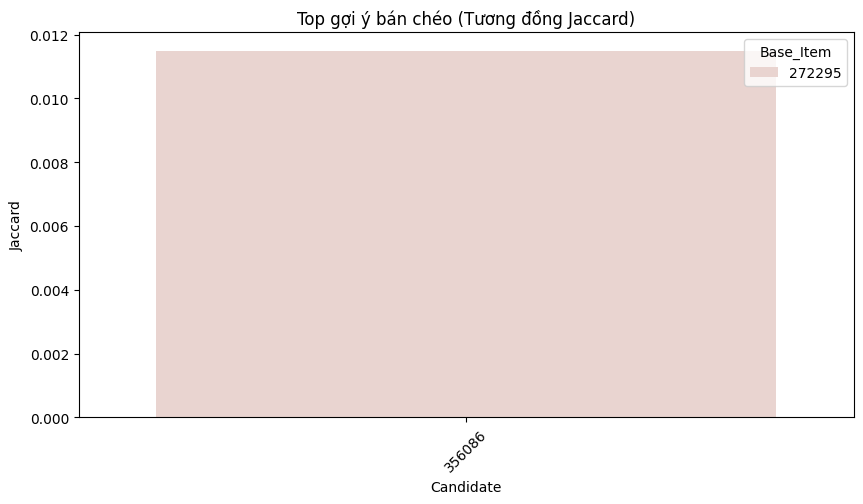


 ĐANG ĐÁNH GIÁ HIỆU QUẢ CỦA PHƯƠNG PHÁP HEURISTIC (KIỂM TRA DỮ LIỆU THẬT)
Đang tính điểm cho 4000 cặp để kiểm định...


Đang đánh giá Heuristic: 100%|██████████| 4000/4000 [00:00<00:00, 4156.22it/s]


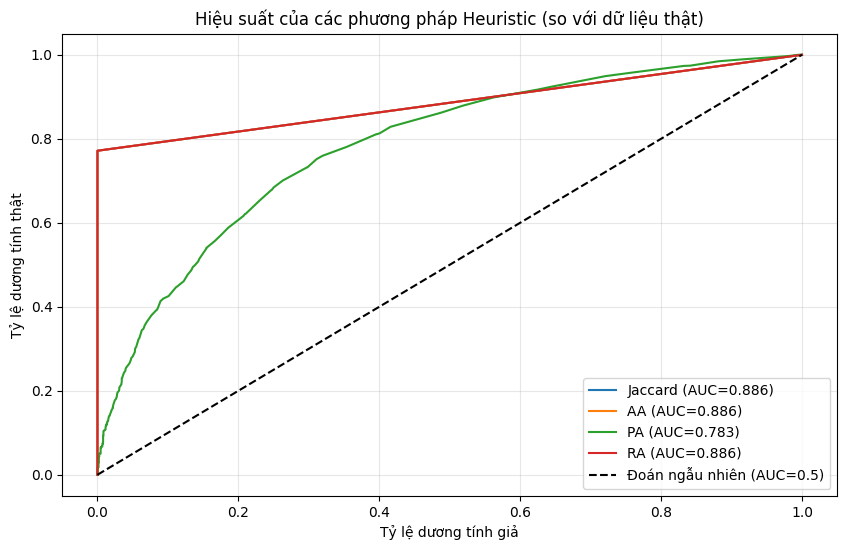


--- TÓM TẮT ĐỘ CHÍNH XÁC CỦA CÁC PHƯƠNG PHÁP HEURISTIC ---


,Phương pháp,AUC
0,Jaccard,0.885750
1,AA,0.885750
3,RA,0.885750
2,PA,0.783484


In [9]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import random
import numpy as np
from tqdm import tqdm # Hiển thị thanh tiến độ
from sklearn.metrics import roc_curve, roc_auc_score # Các chỉ số đánh giá mô hình

# ==============================================================================
# PHẦN A: TẠO GỢI Ý BÁN CHÉO (CROSS-SELL RECOMMENDATION)
# ==============================================================================

# 1. Xác định các Anchor (Core Nodes)
# Lấy tất cả các node được phân loại là 'Core Zone'
anchors = [n for n, c in node_classes.items() if c == 'Core Zone']
# Chọn ra 20 anchor hàng đầu dựa trên bậc của chúng (có nhiều kết nối nhất)
top_anchors = sorted(anchors, key=lambda n: G_category.degree(n), reverse=True)[:20]

# 2. Tìm các cạnh hiện có giữa các danh mục (dùng làm đường cơ sở)
existing_rows = []
for u in top_anchors:
    for v in G_full.neighbors(u): # Duyệt qua các hàng xóm của node anchor trong đồ thị đầy đủ
        if v not in G_category.nodes(): # Nếu hàng xóm không thuộc đồ thị con G_category (nghĩa là ngoài danh mục)
            existing_rows.append({'Base_Item': u, 'Candidate': v, 'Type': 'Existing'})

df_existing = pd.DataFrame(existing_rows) # Chuyển kết quả thành DataFrame

# Hàm tính toán các chỉ số tương đồng và liên kết giữa hai node
def get_score_details(graph, u, v):
    try:
        # Chỉ số Jaccard: Đo lường sự chồng chéo của các hàng xóm
        jaccard = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
        # Chỉ số Adamic-Adar: Đo lường sự tương đồng dựa trên các hàng xóm chung
        aa = list(nx.adamic_adar_index(graph, [(u, v)]))[0][2]
        # Mức độ ưu tiên đính kèm (Preferential Attachment): Tích của bậc hai node
        pa = graph.degree(u) * graph.degree(v)
        # Chỉ số phân bổ tài nguyên (Resource Allocation): Đánh giá tài nguyên được chia sẻ
        ra = list(nx.resource_allocation_index(graph, [(u, v)]))[0][2]
    except:
        # Gán giá trị 0 nếu có lỗi khi tính toán các chỉ số (ví dụ: node không tồn tại)
        jaccard, aa, pa, ra = 0, 0, 0, 0
    return jaccard, aa, pa, ra

# 3. Tìm các ứng viên mới (Gợi ý)
new_rows = []
full_nodes = list(G_full.nodes()) # Danh sách tất cả các node trong đồ thị đầy đủ

# Duyệt qua từng node anchor để tạo gợi ý
for u in tqdm(top_anchors, desc="Đang tạo ứng viên"):
    nbrs = set(G_full.neighbors(u)) # Tập hợp các hàng xóm hiện có của node anchor
    # Lấy mẫu ngẫu nhiên 50 node không phải là hàng xóm hiện có
    potential = random.sample(full_nodes, 50)
    for v in potential:
        if v != u and v not in nbrs: # Đảm bảo không gợi ý chính nó hoặc hàng xóm hiện có
            jc, aa, pa, ra = get_score_details(G_full, u, v) # Tính các chỉ số cho cặp (u, v)
            if jc > 0: # Chỉ lấy nếu có sự tương đồng Jaccard (khác 0)
                new_rows.append({
                    'Base_Item': u, 'Candidate': v, 'Type': 'Suggested',
                    'Jaccard': jc, 'Adamic_Adar': aa, 'Pref_Attach': pa, 'Resource_Alloc': ra
                })

df_new = pd.DataFrame(new_rows) # Chuyển kết quả thành DataFrame

# 4. Tạo bảng tổng hợp gợi ý bán chéo
if not df_existing.empty:
    tqdm.pandas(desc="Đang tính điểm các cặp hiện có")
    # Tính toán các chỉ số cho các cặp cạnh hiện có
    df_existing[['Jaccard', 'Adamic_Adar', 'Pref_Attach', 'Resource_Alloc']] = df_existing.progress_apply(
        lambda x: pd.Series(get_score_details(G_full, x['Base_Item'], x['Candidate'])), axis=1
    )

# Nối DataFrame các cạnh hiện có và các gợi ý mới
cross_sell_table = pd.concat([df_existing, df_new], ignore_index=True)
# Sắp xếp bảng gợi ý
cross_sell_table = cross_sell_table.sort_values(['Type', 'Jaccard'], ascending=[True, False])

print("\n--- BẢNG GỢI Ý BÁN CHÉO (XEM TRƯỚC) ---")
display(cross_sell_table.head(10))

# 5. Trực quan hóa biểu đồ cột (Top gợi ý)
# Lấy 10 gợi ý hàng đầu từ các đề xuất mới
top_sugg = cross_sell_table[cross_sell_table['Type'] == 'Suggested'].head(10)
if not top_sugg.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_sugg, x='Candidate', y='Jaccard', hue='Base_Item', dodge=False)
    plt.title("Top gợi ý bán chéo (Tương đồng Jaccard)")
    plt.xticks(rotation=45) # Xoay nhãn trục x để dễ đọc
    plt.show()


# ==============================================================================
# PHẦN B: ĐÁNH GIÁ ĐỊNH LƯỢNG (SO SÁNH VỚI DỮ LIỆU THẬT)
# ==============================================================================
print("\n" + "="*60)
print(" ĐANG ĐÁNH GIÁ HIỆU QUẢ CỦA PHƯƠNG PHÁP HEURISTIC (KIỂM TRA DỮ LIỆU THẬT)")
print("="*60)

# --- 1. Tạo tập dữ liệu kiểm thử nhanh (Bộ dữ liệu đánh giá nhỏ) ---
# Số lượng mẫu để đánh giá (cạnh thật và cạnh giả)
n_eval_samples = 2000
eval_data = [] # Danh sách lưu trữ dữ liệu đánh giá

# Lấy mẫu dương (Positive Samples - Các cạnh có thật trong đồ thị)
real_edges = list(G_full.edges())
if len(real_edges) > n_eval_samples:
    pos_samples = random.sample(real_edges, n_eval_samples)
else:
    pos_samples = real_edges

# Thêm các mẫu dương vào dữ liệu đánh giá với nhãn 1
for u, v in pos_samples:
    eval_data.append({'u': u, 'v': v, 'Label': 1})

# Lấy mẫu âm (Negative Samples - Các cặp node không có cạnh trong đồ thị)
all_nodes_list = list(G_full.nodes())
count = 0
while count < n_eval_samples:
    u, v = random.sample(all_nodes_list, 2) # Chọn ngẫu nhiên 2 node
    if not G_full.has_edge(u, v): # Nếu không có cạnh giữa chúng
        eval_data.append({'u': u, 'v': v, 'Label': 0})
        count += 1

df_eval = pd.DataFrame(eval_data) # Chuyển dữ liệu đánh giá thành DataFrame

# --- 2. Tính điểm Heuristic cho tập kiểm thử ---
print(f"Đang tính điểm cho {len(df_eval)} cặp để kiểm định...")
tqdm.pandas(desc="Đang đánh giá Heuristic")
# Áp dụng hàm get_score_details để tính các chỉ số Heuristic cho từng cặp node
df_eval[['Jaccard', 'AA', 'PA', 'RA']] = df_eval.progress_apply(
    lambda x: pd.Series(get_score_details(G_full, x['u'], x['v'])), axis=1
)

# --- 3. Vẽ biểu đồ ROC và tính AUC ---
heuristics = ['Jaccard', 'AA', 'PA', 'RA'] # Danh sách các phương pháp Heuristic
plt.figure(figsize=(10, 6)) # Thiết lập kích thước biểu đồ

results = []
for metric in heuristics:
    y_true = df_eval['Label'] # Nhãn thật
    y_scores = df_eval[metric].fillna(0) # Điểm số từ phương pháp Heuristic, điền 0 cho giá trị thiếu

    try:
        auc = roc_auc_score(y_true, y_scores) # Tính AUC (Area Under the Curve)
        results.append({'Phương pháp': metric, 'AUC': auc})
        fpr, tpr, _ = roc_curve(y_true, y_scores) # Tính FPR và TPR cho đường cong ROC
        plt.plot(fpr, tpr, label=f'{metric} (AUC={auc:.3f})') # Vẽ đường cong ROC
    except: continue # Bỏ qua nếu có lỗi (ví dụ: tất cả điểm đều giống nhau)

# Vẽ đường tham chiếu cho dự đoán ngẫu nhiên
plt.plot([0, 1], [0, 1], 'k--', label='Đoán ngẫu nhiên (AUC=0.5)')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Hiệu suất của các phương pháp Heuristic (so với dữ liệu thật)')
plt.legend() # Hiển thị chú giải
plt.grid(True, alpha=0.3) # Hiển thị lưới
plt.show()

print("\n--- TÓM TẮT ĐỘ CHÍNH XÁC CỦA CÁC PHƯƠNG PHÁP HEURISTIC ---")
display(pd.DataFrame(results).sort_values('AUC', ascending=False)) # Hiển thị kết quả AUC

### PART 5: LINK PREDICTION MODEL (MACHINE LEARNING)
**Mục đích:**
- Đánh giá định lượng hiệu quả của các phương pháp Heuristic (So sánh với Ground Truth).
- Huấn luyện mô hình **Machine Learning (Logistic Regression)** để tối ưu hóa dự đoán.
- Sử dụng **StandardScaler** và **Hyperparameter Tuning** để khắc phục lỗi overconfidence.
- Đánh giá mô hình bằng AUC, Precision@K, Recall@K.

  LOGISTIC REGRESSION VỚI MIXED NEGATIVE SAMPLING (CÓ ĐẶC TRƯNG K-CORE)

Đang trích xuất đặc trưng...


Extracting (L=0): 100%|██████████| 2704/2704 [00:00<00:00, 43410.55it/s]



--- Bắt đầu tối ưu hóa tham số C ---
C=0.001   -> AUC=0.8110
C=0.01    -> AUC=0.8175
C=0.1     -> AUC=0.8177
C=1       -> AUC=0.8134
C=10      -> AUC=0.8128
C=100     -> AUC=0.8126

=> Chọn mô hình tốt nhất với C=0.1 (AUC=0.8177)

Trọng số mô hình tối ưu:


,Đặc trưng,Trọng số
1,AA,2.857839
4,DegDiff,0.740946
6,KCore_v,-0.017108
5,KCore_u,-0.020080
0,Jaccard,-0.478395
2,PA,-1.093979
3,RA,-1.653412


,K,P@K,R@K,MAP@K
0,10,0.700,0.002589,0.594048
1,50,0.860,0.015902,0.724976
2,100,0.900,0.033284,0.782633
3,200,0.885,0.065459,0.777185


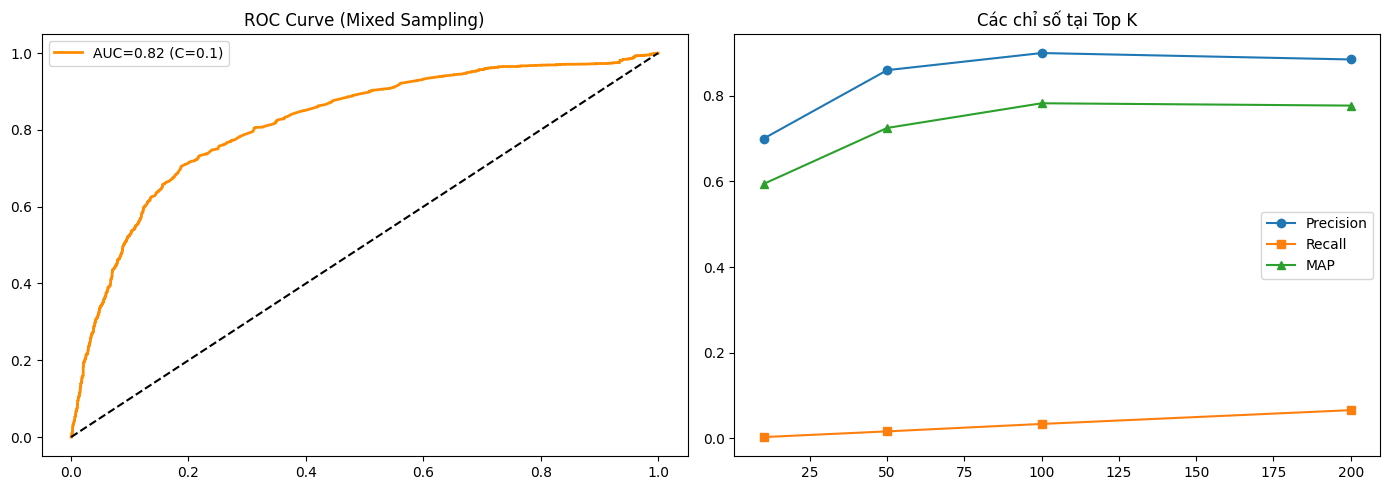

In [10]:
# --- IMPORT THƯ VIỆN CẦN THIẾT ---
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import random
from tqdm import tqdm

print("="*70)
print("  LOGISTIC REGRESSION VỚI MIXED NEGATIVE SAMPLING (CÓ ĐẶC TRƯNG K-CORE)")
print("="*70)

# ==========================================
# 1. CHUẨN BỊ DỮ LIỆU
# ==========================================
edges = list(G_category.edges())
if len(edges) > 20000:
    edges = random.sample(edges, 20000)

train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)

G_train = G_category.edge_subgraph(train_edges).copy()
G_train.add_nodes_from(G_category.nodes())

# --- CHIẾN LƯỢC LẤY MẪU HỖN HỢP (MIXED STRATEGY) ---
def smart_negative_sampling_mixed(graph, pos_edges, n_samples):
    negatives = set()
    nodes = list(graph.nodes())
    degrees = dict(graph.degree())
    threshold = np.percentile(list(degrees.values()), 90)
    hubs = [n for n, d in degrees.items() if d >= threshold]
    def is_valid_neg(u, v):
        if u == v: return False
        if graph.has_edge(u, v): return False
        if (u, v) in negatives or (v, u) in negatives: return False
        return True
    target_hub = int(n_samples * 0.3)
    attempts = 0
    while len(negatives) < target_hub and attempts < target_hub * 50:
        if len(hubs) < 2: break
        u, v = random.sample(hubs, 2)
        if is_valid_neg(u, v):
            negatives.add((u, v))
        attempts += 1
    target_hard = int(n_samples * 0.3)
    target_total_hard = len(negatives) + target_hard
    for u, v in pos_edges:
        if len(negatives) >= target_total_hard: break
        neighbors_u = list(graph.neighbors(u))
        if len(neighbors_u) > 1:
            w = random.choice(neighbors_u)
            if w != v and is_valid_neg(v, w):
                negatives.add((v, w))
    attempts = 0
    while len(negatives) < n_samples and attempts < n_samples * 50:
        u, v = random.sample(nodes, 2)
        if is_valid_neg(u, v):
            negatives.add((u, v))
        attempts += 1
    return list(negatives)

train_neg = smart_negative_sampling_mixed(G_train, train_edges, len(train_edges))
test_neg = smart_negative_sampling_mixed(G_train, test_edges, len(test_edges))

# ==========================================
# 2. KỸ THUẬT ĐẶC TRƯNG (FEATURE ENGINEERING)
# ==========================================
def extract_features(graph, pairs, label, core_nums=None):
    data = []
    if core_nums is None:
        try:
            core_nums = nx.core_number(graph)
        except:
            core_nums = {n: 0 for n in graph.nodes()}
    for u, v in tqdm(pairs, desc=f"Extracting (L={label})"):
        try:
            jc = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
            aa = list(nx.adamic_adar_index(graph, [(u, v)]))[0][2]
            pa = graph.degree(u) * graph.degree(v)
            ra = list(nx.resource_allocation_index(graph, [(u, v)]))[0][2]
            deg_diff = abs(graph.degree(u) - graph.degree(v))
            kcore_u = core_nums.get(u, 0)
            kcore_v = core_nums.get(v, 0)
            data.append([jc, aa, pa, ra, deg_diff, kcore_u, kcore_v, label])
        except: continue
    return pd.DataFrame(data, columns=['Jaccard', 'AA', 'PA', 'RA', 'DegDiff', 'KCore_u', 'KCore_v', 'Label'])

print("\nĐang trích xuất đặc trưng...")
core_nums = nx.core_number(G_train)
df_train = pd.concat([
    extract_features(G_train, train_edges, 1, core_nums),
    extract_features(G_train, train_neg, 0, core_nums)
]).sample(frac=1, random_state=42).reset_index(drop=True)

df_test = pd.concat([
    extract_features(G_train, test_edges, 1, core_nums),
    extract_features(G_train, test_neg, 0, core_nums)
]).reset_index(drop=True)

# ==========================================
# 3. HUẤN LUYỆN & TỐI ƯU HÓA
# ==========================================
features = ['Jaccard', 'AA', 'PA', 'RA', 'DegDiff', 'KCore_u', 'KCore_v']
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['Label']
X_test = scaler.transform(df_test[features])
y_test = df_test['Label']

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_auc = 0
best_model = None
best_c = 0
print("\n--- Bắt đầu tối ưu hóa tham số C ---")
for c in C_values:
    model_tmp = LogisticRegression(C=c, max_iter=1000, class_weight='balanced', random_state=42)
    model_tmp.fit(X_train, y_train)
    y_probs_tmp = model_tmp.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_probs_tmp)
    print(f"C={c:<7} -> AUC={score:.4f}")
    if score > best_auc:
        best_auc = score
        best_model = model_tmp
        best_c = c
print(f"\n=> Chọn mô hình tốt nhất với C={best_c} (AUC={best_auc:.4f})")
model = best_model
weights = pd.DataFrame({'Đặc trưng': features, 'Trọng số': model.coef_[0]})
print("\nTrọng số mô hình tối ưu:")
display(weights.sort_values(by='Trọng số', ascending=False))

y_probs = model.predict_proba(X_test)[:, 1]
def evaluate_at_k(y_true, y_scores, k_list):
    df = pd.DataFrame({'label': y_true, 'score': y_scores}).sort_values('score', ascending=False)
    metrics = []
    total_pos = df['label'].sum()
    for k in k_list:
        top_k = df.head(k)
        pk = top_k['label'].sum() / k
        rk = top_k['label'].sum() / total_pos if total_pos > 0 else 0
        hits = 0
        precs = []
        for i in range(k):
            if df.iloc[i]['label'] == 1:
                hits += 1
                precs.append(hits / (i + 1))
        mapk = sum(precs) / min(k, total_pos) if precs else 0
        metrics.append({'K': k, 'P@K': pk, 'R@K': rk, 'MAP@K': mapk})
    return pd.DataFrame(metrics)

eval_df = evaluate_at_k(y_test, y_probs, [10, 50, 100, 200])
display(eval_df)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fpr, tpr, _ = roc_curve(y_test, y_probs)
ax[0].plot(fpr, tpr, label=f'AUC={best_auc:.2f} (C={best_c})', color='darkorange', lw=2)
ax[0].plot([0,1], [0,1], 'k--')
ax[0].set_title('ROC Curve (Mixed Sampling)')
ax[0].legend()
ax[1].plot(eval_df['K'], eval_df['P@K'], marker='o', label='Precision')
ax[1].plot(eval_df['K'], eval_df['R@K'], marker='s', label='Recall')
ax[1].plot(eval_df['K'], eval_df['MAP@K'], marker='^', label='MAP')
ax[1].set_title('Các chỉ số tại Top K')
ax[1].legend()
plt.tight_layout()
plt.show()

  RANDOM FOREST (CÓ ĐẶC TRƯNG K-CORE)

[Bước 1] Trích xuất đặc trưng cho RF...


Extracting RF (L=0): 100%|██████████| 2704/2704 [00:00<00:00, 37920.70it/s]



[Bước 2] Đang huấn luyện Random Forest...

=> Random Forest AUC: 0.6255


,K,P@K,R@K,MAP@K
0,10,0.80,0.002959,0.670873
1,50,0.78,0.014423,0.608783
2,100,0.77,0.028476,0.602820
3,200,0.78,0.057692,0.607754


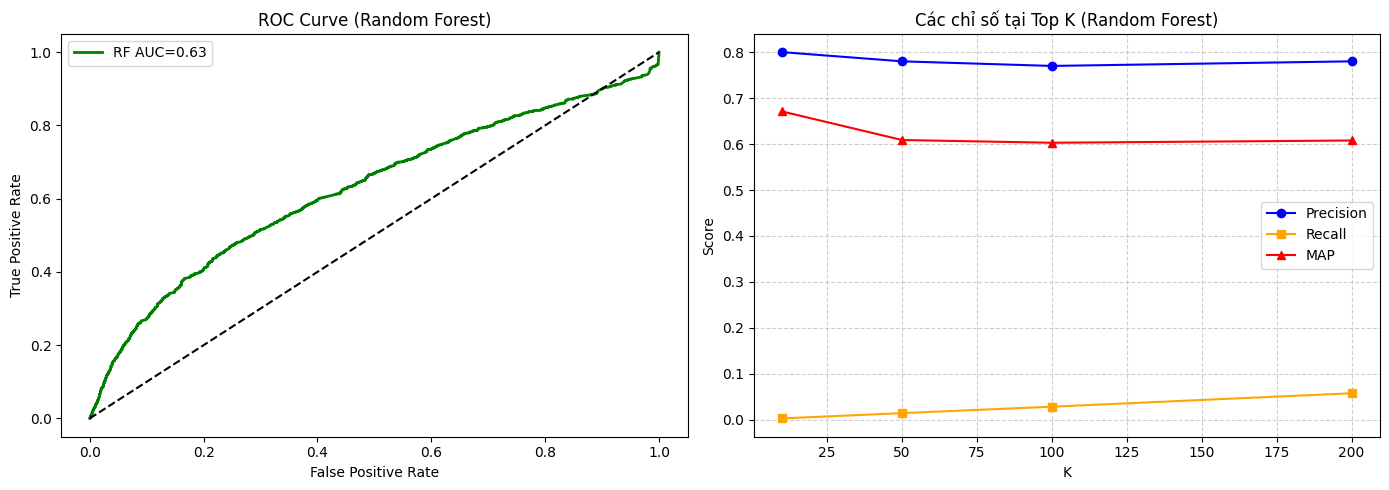


Đặc trưng quan trọng nhất:


,Feature,Importance
6,Clust_Avg,0.352490
2,PA,0.237148
4,DegDiff,0.096522
0,Jaccard,0.072228
8,KCore_v,0.060478
1,AA,0.055281
7,KCore_u,0.054340
3,RA,0.045631
5,Triangles,0.025883


In [11]:
# --- IMPORT THƯ VIỆN CẦN THIẾT ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm

print("="*70)
print("  RANDOM FOREST (CÓ ĐẶC TRƯNG K-CORE)")
print("="*70)

# ==========================================
# 1. TRÍCH XUẤT ĐẶC TRƯNG (FEATURE ENGINEERING)
# ==========================================
def extract_features_rf(graph, pairs, label, core_nums=None):
    data = []
    clustering = nx.clustering(graph)
    if core_nums is None:
        try:
            core_nums = nx.core_number(graph)
        except:
            core_nums = {n: 0 for n in graph.nodes()}
    for u, v in tqdm(pairs, desc=f"Extracting RF (L={label})"):
        try:
            jc = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
            aa = list(nx.adamic_adar_index(graph, [(u, v)]))[0][2]
            pa = graph.degree(u) * graph.degree(v)
            ra = list(nx.resource_allocation_index(graph, [(u, v)]))[0][2]
            deg_diff = abs(graph.degree(u) - graph.degree(v))
            cn_set = set(nx.common_neighbors(graph, u, v))
            triangles = len([n for n in cn_set if graph.has_edge(u, n) or graph.has_edge(v, n)])
            clust_avg = (clustering.get(u, 0) + clustering.get(v, 0)) / 2
            kcore_u = core_nums.get(u, 0)
            kcore_v = core_nums.get(v, 0)
            data.append([jc, aa, pa, ra, deg_diff, triangles, clust_avg, kcore_u, kcore_v, label])
        except: continue
    return pd.DataFrame(data, columns=[
        'Jaccard', 'AA', 'PA', 'RA', 'DegDiff',
        'Triangles', 'Clust_Avg', 'KCore_u', 'KCore_v', 'Label'
    ])

print("\n[Bước 1] Trích xuất đặc trưng cho RF...")
core_nums = nx.core_number(G_train)
df_train_rf = pd.concat([
    extract_features_rf(G_train, train_edges, 1, core_nums),
    extract_features_rf(G_train, train_neg, 0, core_nums)
]).sample(frac=1, random_state=42).reset_index(drop=True)

df_test_rf = pd.concat([
    extract_features_rf(G_train, test_edges, 1, core_nums),
    extract_features_rf(G_train, test_neg, 0, core_nums)
]).reset_index(drop=True)

features_rf = ['Jaccard', 'AA', 'PA', 'RA', 'DegDiff', 'Triangles', 'Clust_Avg', 'KCore_u', 'KCore_v']

scaler_rf = StandardScaler()
X_train_rf = scaler_rf.fit_transform(df_train_rf[features_rf])
y_train_rf = df_train_rf['Label']
X_test_rf = scaler_rf.transform(df_test_rf[features_rf])
y_test_rf = df_test_rf['Label']

print("\n[Bước 2] Đang huấn luyện Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_leaf=4,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_rf, y_train_rf)

y_probs_rf = rf_model.predict_proba(X_test_rf)[:, 1]
auc_rf = roc_auc_score(y_test_rf, y_probs_rf)
print(f"\n=> Random Forest AUC: {auc_rf:.4f}")

def evaluate_at_k(y_true, y_scores, k_list):
    df = pd.DataFrame({'label': y_true, 'score': y_scores}).sort_values('score', ascending=False)
    metrics = []
    total_pos = df['label'].sum()
    for k in k_list:
        top_k = df.head(k)
        pk = top_k['label'].sum() / k
        rk = top_k['label'].sum() / total_pos if total_pos > 0 else 0
        hits = 0
        precs = []
        for i in range(k):
            if df.iloc[i]['label'] == 1:
                hits += 1
                precs.append(hits / (i + 1))
        mapk = sum(precs) / min(k, total_pos) if precs else 0
        metrics.append({'K': k, 'P@K': pk, 'R@K': rk, 'MAP@K': mapk})
    return pd.DataFrame(metrics)

eval_df_rf = evaluate_at_k(y_test_rf, y_probs_rf, [10, 50, 100, 200])
display(eval_df_rf)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fpr, tpr, _ = roc_curve(y_test_rf, y_probs_rf)
ax[0].plot(fpr, tpr, label=f'RF AUC={auc_rf:.2f}', color='green', lw=2)
ax[0].plot([0,1], [0,1], 'k--')
ax[0].set_title('ROC Curve (Random Forest)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

ax[1].plot(eval_df_rf['K'], eval_df_rf['P@K'], marker='o', label='Precision', color='blue')
ax[1].plot(eval_df_rf['K'], eval_df_rf['R@K'], marker='s', label='Recall', color='orange')
ax[1].plot(eval_df_rf['K'], eval_df_rf['MAP@K'], marker='^', label='MAP', color='red')
ax[1].set_title('Các chỉ số tại Top K (Random Forest)')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Score')
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

plt.tight_layout()
plt.show()

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features_rf, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nĐặc trưng quan trọng nhất:")
display(feat_imp)

### PART 6: COMPARATIVE CASE STUDY
**Mục đích:**
- So sánh trực tiếp hiệu quả của ML và Heuristic trên hai đối tượng cụ thể: **Core Node** và **Periphery Node**.
- Sử dụng **Ego Network** để minh họa sự khác biệt về mật độ.
- Sử dụng **Biểu đồ Cột** và **Phân tích đóng góp đặc trưng**.

--- CÁC MỤC TIÊU PHÂN TÍCH CHIẾN LƯỢC ---
NODE LÕI: 321808 | NODE NGOẠI VI: 524461

Chiến lược gợi ý cho NODE LÕI (321808):


,Candidate,Strategy,ML_Score,Jaccard,AA,PA
335,221124,Cá nhân hóa (ML),0.999289,0.00813,1.442695,123
196,267445,Cá nhân hóa (ML),0.997969,0.00813,0.621335,123
34,518351,Cá nhân hóa (ML),0.997481,0.00813,0.434294,123
107,465566,Cá nhân hóa (ML),0.997402,0.01626,0.948274,246
140,7010,Cá nhân hóa (ML),0.997386,0.00813,0.402430,123



Chiến lược gợi ý cho NODE NGOẠI VI (524461):


,Candidate,Strategy,ML_Score,Jaccard,AA,PA
24,77993,Cá nhân hóa (ML),0.747207,0.400000,1.663693,40
7,536974,Cá nhân hóa (ML),0.618079,0.083333,1.202246,160
6,140685,Cá nhân hóa (ML),0.617119,0.076923,0.721348,40
19,56099,Cá nhân hóa (ML),0.604489,0.181818,0.731690,30
35,181699,Cá nhân hóa (ML),0.594981,0.071429,0.721348,50


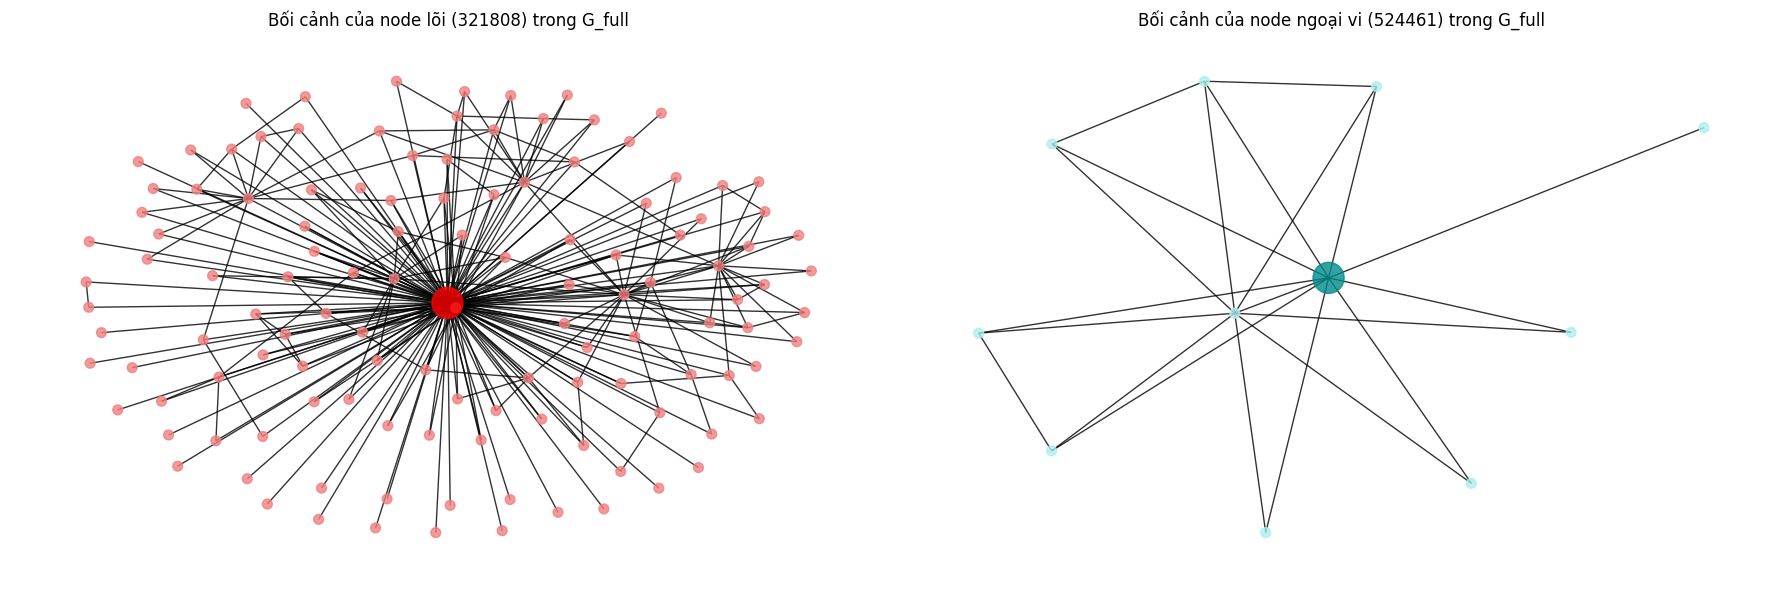

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import random
import matplotlib.patches as mpatches # Để tùy chỉnh chú giải (legend)

# --- 1. CHUẨN BỊ DỮ LI LIỆU VÀ CHỌN NODE MỤC TIÊU ---
# Lấy 5 item phổ biến nhất dựa trên bậc của node trong đồ thị đầy đủ G_full
top_popular_items_full = sorted(dict(G_full.degree()).items(), key=lambda x: x[1], reverse=True)[:5]
popular_ids = [n for n, d in top_popular_items_full] # ID của các item phổ biến (cho fallback)

# Tính toán core_nums cho G_full để sử dụng trong get_smart_recommendations
core_nums_for_full = nx.core_number(G_full)

# Chọn một node lõi (u_core) để phân tích từ G_full
# Đảm bảo node_classes đã được tính trên G_category và các node tồn tại trong G_full
core_nodes_from_full = [n for n, c in node_classes.items() if c == 'Core Zone' and n in G_full.nodes()]
if core_nodes_from_full:
    # Sắp xếp các node lõi theo bậc của chúng trong G_full
    u_core = sorted(core_nodes_from_full, key=lambda n: G_full.degree(n), reverse=True)[0]
else:
    # Fallback nếu không tìm thấy Core Zone hoặc không hợp lệ trong G_full
    u_core = max(dict(G_full.degree()).items(), key=lambda x: x[1])[0]

# Chọn một node ngoại vi (u_periphery) để phân tích từ G_full
periphery_pool_from_full = [n for n, c in node_classes.items() if c == 'Outer Periphery' and n in G_full.nodes()]
if periphery_pool_from_full:
    u_periphery = random.choice(periphery_pool_from_full)
    # Đảm bảo u_periphery không trùng với u_core
    attempts = 0
    while u_periphery == u_core and attempts < 100:
        u_periphery = random.choice(periphery_pool_from_full)
        attempts += 1
    if u_periphery == u_core:
        # Nếu vẫn trùng sau nhiều lần thử, chọn một node khác bất kỳ từ G_full không phải core
        potential_periphery_candidates = [n for n in G_full.nodes() if n != u_core and n not in core_nodes_from_full]
        if potential_periphery_candidates:
            u_periphery = random.choice(potential_periphery_candidates)
        else:
            u_periphery = u_core # Fallback cực đoan
else:
    # Fallback nếu không tìm thấy Outer Periphery
    potential_periphery_candidates = [n for n in G_full.nodes() if n != u_core and n not in core_nodes_from_full]
    if potential_periphery_candidates:
        u_periphery = random.choice(potential_periphery_candidates)
    else:
        u_periphery = u_core # Fallback cực đoan

print(f"--- CÁC MỤC TIÊU PHÂN TÍCH CHIẾN LƯỢC ---")
print(f"NODE LÕI: {u_core} | NODE NGOẠI VI: {u_periphery}")


# --- 2. HÀM GỢI Ý THÔNG MINH (CẬP NHẬT: HIỂN THỊ SO SÁNH) ---
def get_smart_recommendations(graph, anchor_node, model, scaler, popular_items, core_nums_dict, n_samples=500):
    # A. Tìm các ứng viên tiềm năng
    candidates = set()
    # Các ứng viên là "hàng xóm của hàng xóm" (node cách 2 bước) của anchor_node
    for nbr in graph.neighbors(anchor_node):
        candidates.update(graph.neighbors(nbr))

    candidates.discard(anchor_node) # Loại bỏ chính node anchor
    candidates.difference_update(set(graph.neighbors(anchor_node))) # Loại bỏ các hàng xóm trực tiếp
    candidate_list = list(candidates)[:n_samples] # Giới hạn số lượng ứng viên

    # B. Chấm điểm ML và Heuristic cho các ứng viên
    if candidate_list:
        data = []
        valid_cands = []
        for v in candidate_list:
            if not graph.has_node(v): # Đảm bảo node ứng viên tồn tại trong đồ thị
                continue
            try:
                # Tính toán các đặc trưng Heuristic cho cặp (anchor_node, v)
                jc = list(nx.jaccard_coefficient(graph, [(anchor_node, v)]))[0][2]
                aa = list(nx.adamic_adar_index(graph, [(anchor_node, v)]))[0][2]
                pa = graph.degree(anchor_node) * graph.degree(v)
                ra = list(nx.resource_allocation_index(graph, [(anchor_node, v)]))[0][2]
                deg_diff = abs(graph.degree(anchor_node) - graph.degree(v)) # Chênh lệch bậc

                # Lấy số k-core từ dictionary được cung cấp
                kcore_u = core_nums_dict.get(anchor_node, 0)
                kcore_v = core_nums_dict.get(v, 0)

                # Thêm tất cả các đặc trưng bao gồm số k-core
                data.append([jc, aa, pa, ra, deg_diff, kcore_u, kcore_v])
                valid_cands.append(v)
            except: continue # Bỏ qua nếu có lỗi

        if data:
            # Cập nhật feature_cols để bao gồm KCore_u và KCore_v
            feature_cols = ['Jaccard', 'AA', 'PA', 'RA', 'DegDiff', 'KCore_u', 'KCore_v']
            df_features = pd.DataFrame(data, columns=feature_cols)

            # Kiểm tra xem tất cả các cột đặc trưng có mặt trước khi scale
            if not all(f in df_features.columns for f in feature_cols):
                print(f"Warning: Missing expected feature columns in df_features. Expected: {feature_cols}, Got: {df_features.columns}")
                return pd.DataFrame() # Trả về DataFrame rỗng nếu thiếu đặc trưng

            X_input = scaler.transform(df_features) # Chuẩn hóa đặc trưng

            # Dự đoán điểm số từ mô hình Machine Learning
            ml_scores = model.predict_proba(X_input)[:, 1]

            # Tổng hợp kết quả để so sánh giữa ML và Heuristic
            results = df_features.copy()
            results['Candidate'] = valid_cands
            results['ML_Score'] = ml_scores
            results['Strategy'] = 'Cá nhân hóa (ML)' # Đặt tên chiến lược

            # Lọc ra Top 5 gợi ý chất lượng cao nhất dựa trên điểm ML
            high_quality = results.sort_values('ML_Score', ascending=False).head(5)

            # Sắp xếp lại thứ tự các cột để hiển thị dễ đọc hơn
            cols = ['Candidate', 'Strategy', 'ML_Score', 'Jaccard', 'AA', 'PA']
            return high_quality[cols]

    # C. Kịch bản dự phòng (FALLBACK) nếu không tìm thấy gợi ý ML
    # Gợi ý các item phổ biến nhất nếu không có ứng viên hoặc không thể tính toán điểm ML
    fallback_recs = pd.DataFrame({
        'Candidate': popular_items,
        'Strategy': 'Dự phòng phổ biến',
        'ML_Score': [0.99]*len(popular_items), # Điểm ML cao giả định cho fallback
        'Jaccard': [0.0]*len(popular_items), # Heuristic 0 vì đây là fallback
        'AA': [0.0]*len(popular_items),
        'PA': [0.0]*len(popular_items)
    })
    return fallback_recs

# --- 3. CHẠY VÀ HIỂN THỊ CÁC GỢI Ý CHIẾN LƯỢC ---
print(f"\nChiến lược gợi ý cho NODE LÕI ({u_core}):")
# Gọi hàm gợi ý cho node lõi, truyền core_nums_for_full
display(get_smart_recommendations(G_full, u_core, model, scaler, popular_ids, core_nums_for_full))

print(f"\nChiến lược gợi ý cho NODE NGOẠI VI ({u_periphery}):")
# Gọi hàm gợi ý cho node ngoại vi, truyền core_nums_for_full
display(get_smart_recommendations(G_full, u_periphery, model, scaler, popular_ids, core_nums_for_full))

# --- 4. TRỰC QUAN HÓA BỐI CẢNH CỦA NODE (Giữ nguyên cấu trúc) ---
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Hàm vẽ đồ thị ego (đồ thị con xung quanh một node)
def draw_ego_simple(g, central_node, ax, central_node_color, neighbor_color, central_node_size, neighbor_size, title):
    if g.has_node(central_node):
        ego_g = nx.ego_graph(g, central_node)
        colors = []
        sizes = []
        for node in ego_g.nodes():
            if node == central_node:
                colors.append(central_node_color)
                sizes.append(central_node_size)
            else:
                colors.append(neighbor_color)
                sizes.append(neighbor_size)
        # Sử dụng spring_layout để các node không chồng chéo nhau
        pos_ego = nx.spring_layout(ego_g, seed=42) # Đảm bảo vị trí ổn định
        nx.draw(ego_g, pos_ego, ax=ax, node_color=colors, node_size=sizes, with_labels=False, alpha=0.8)
        ax.set_title(title)

# Vẽ đồ thị ego cho node lõi với màu sắc và kích thước tùy chỉnh
draw_ego_simple(
    G_full, u_core, ax[0],
    central_node_color='red',
    neighbor_color='lightcoral',
    central_node_size=500,
    neighbor_size=50,
    title=f"Bối cảnh của node lõi ({u_core}) trong G_full"
)

# Vẽ đồ thị ego cho node ngoại vi với màu sắc và kích thước tùy chỉnh
draw_ego_simple(
    G_full, u_periphery, ax[1],
    central_node_color='darkcyan',
    neighbor_color='paleturquoise',
    central_node_size=500,
    neighbor_size=50,
    title=f"Bối cảnh của node ngoại vi ({u_periphery}) trong G_full"
)

plt.tight_layout() # Điều chỉnh bố cục để tránh chồng chéo
plt.show()

(Đánh giá trên tập dữ liệu kiểm thử - Dữ liệu thật)


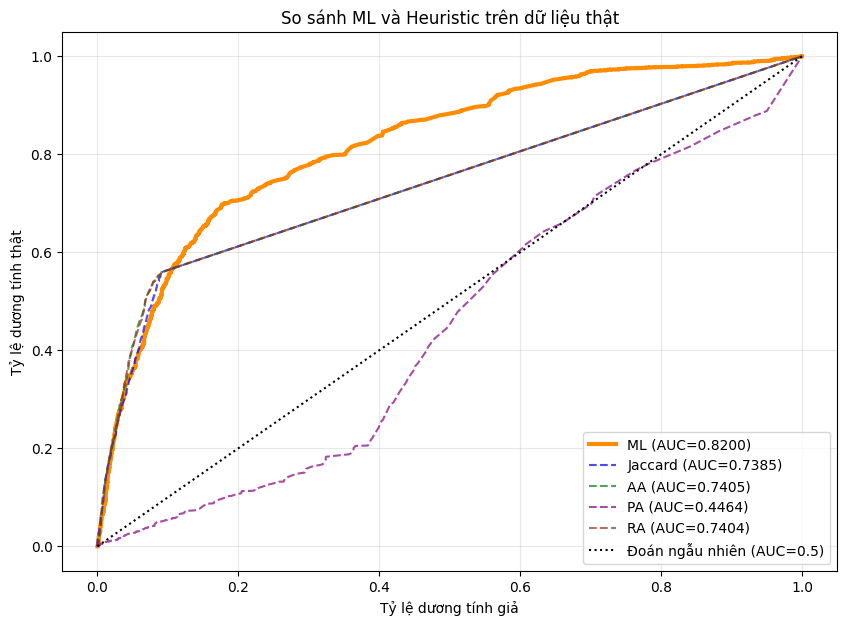

ML cải thiện độ chính xác thêm 7.95% so với heuristic tốt nhất.


In [ ]:
# --- ĐÁNH GIÁ CUỐI CÙNG: HỌC MÁY so với HEURISTIC so với DỮ LIỆU THẬT ---
from sklearn.metrics import roc_curve, roc_auc_score

print("(Đánh giá trên tập dữ liệu kiểm thử - Dữ liệu thật)")

plt.figure(figsize=(10, 7))

# 1. Vẽ đường cong ROC cho mô hình Học máy (sử dụng mô hình đã huấn luyện)
y_pred_ml = model.predict_proba(X_test)[:, 1]
auc_ml = roc_auc_score(y_test, y_pred_ml)
fpr_ml, tpr_ml, _ = roc_curve(y_test, y_pred_ml)
plt.plot(fpr_ml, tpr_ml, color='darkorange', lw=3, label=f'ML (AUC={auc_ml:.4f})')

# 2. Vẽ đường cong ROC cho các phương pháp Heuristic (Jaccard, AA, PA...)
heuristics = ['Jaccard', 'AA', 'PA', 'RA']
colors = ['blue', 'green', 'purple', 'brown']
for metric, color in zip(heuristics, colors):
    y_scores = df_test[metric].fillna(0)
    auc_h = roc_auc_score(y_test, y_scores)
    fpr_h, tpr_h, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr_h, tpr_h, color=color, linestyle='--', alpha=0.7, label=f'{metric} (AUC={auc_h:.4f})')

plt.plot([0, 1], [0, 1], 'k:', label='Đoán ngẫu nhiên (AUC=0.5)')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('So sánh ML và Heuristic trên dữ liệu thật')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

best_heuristic_auc = max([roc_auc_score(y_test, df_test[h].fillna(0)) for h in heuristics])
print(f"ML cải thiện độ chính xác thêm {((auc_ml - best_heuristic_auc)*100):.2f}% so với heuristic tốt nhất.")